In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import box
import os
from shapely.geometry import Point
from collections import Counter
from itertools import chain
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore') 

In [6]:
df = pd.read_json(r'D:\Study\Project\RecSys\CP-02\meta-North_Dakota.json', lines=True)

In [7]:
df.shape

(11987, 15)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11987 entries, 0 to 11986
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              11987 non-null  object 
 1   address           11890 non-null  object 
 2   gmap_id           11987 non-null  object 
 3   description       1756 non-null   object 
 4   latitude          11987 non-null  float64
 5   longitude         11987 non-null  float64
 6   category          11930 non-null  object 
 7   avg_rating        11987 non-null  float64
 8   num_of_reviews    11987 non-null  int64  
 9   price             1964 non-null   object 
 10  hours             8715 non-null   object 
 11  MISC              9568 non-null   object 
 12  state             8231 non-null   object 
 13  relative_results  11005 non-null  object 
 14  url               11987 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 1.5+ MB


In [10]:
df.describe()

,latitude,longitude,avg_rating,num_of_reviews
count,11987.000000,11987.000000,11987.000000,11987.000000
mean,47.350646,-99.463497,4.305456,92.563444
std,0.716629,3.513703,0.620997,219.949270
min,28.647890,-104.047715,1.000000,1.000000
25%,46.840714,-101.296677,4.000000,7.000000
50%,46.904631,-99.126083,4.400000,19.000000
75%,47.985279,-97.000267,4.700000,77.000000
max,48.999305,180.000000,5.000000,4828.000000


In [11]:
df.isnull().sum()

name                    0
address                97
gmap_id                 0
description         10231
latitude                0
longitude               0
category               57
avg_rating              0
num_of_reviews          0
price               10023
hours                3272
MISC                 2419
state                3756
relative_results      982
url                     0
dtype: int64

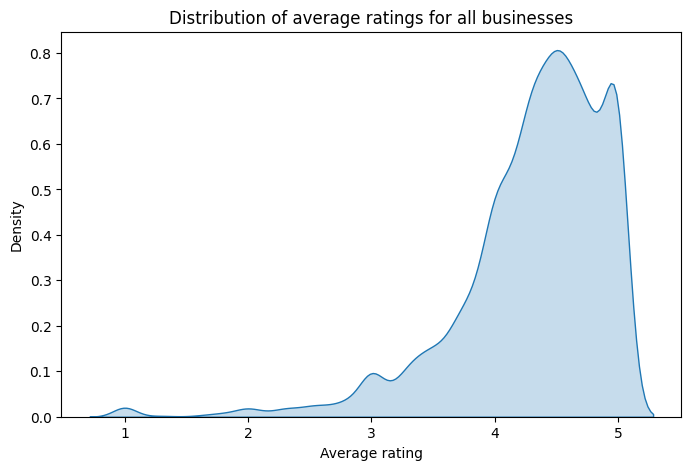

In [83]:
# Plot to show distribution of average ratings of businesses
# Density plot for to have smoothed representation of the distribution because it is a continuous variable
plt.figure(figsize=(8, 5))
sns.kdeplot(df['avg_rating'], fill=True)
plt.title('Distribution of average ratings for all businesses')
plt.xlabel('Average rating')
plt.ylabel('Density')
plt.show()

- Distribution is skewed towards the right indicating that most of the businesses have a higher rating.

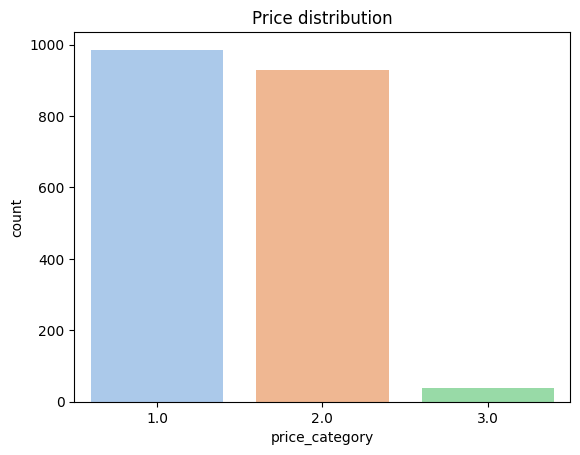

In [57]:
# Converts dollars in price column to categories 1, 2, 3 for easier processing and better readability
def convert_price(price):
    if price == '$':
        return 1
    elif price == '$$':
        return 2
    elif price == '$$$':
        return 3
    
df['price_category'] = df['price'].apply(convert_price)

# Plot to show distribution of price
sns.countplot(x='price_category', data=df, palette='pastel')
plt.title('Price distribution')
plt.show()

- There are around 975 businesses with cheap rates, around 900 businesses with affordable rates and around 25-50 businesses with expensive rates.

- Below are the top 10 highest rated business in the dataset.

In [18]:
company_ratings = df.sort_values(by='avg_rating', ascending=False).head(10)
company_ratings[['name', 'avg_rating']]

,name,avg_rating
4437,County Ditch Number 19,5.0
1164,Karriers Inc,5.0
1193,CHI St. Alexius Leonard P. Nelson Cancer Center,5.0
1191,Clearcheck Workplace Screening,5.0
1190,"Tammy Bearce, LRD",5.0
1189,"Tiah Rigby, NP",5.0
1188,"Melissa Hanson, PA-C",5.0
1187,"Harry Wallner, PT",5.0
2836,Autotronics Unlimited,5.0
2837,"Shocker Hitch, Inc.",5.0


- Below is the total counts of number of business for each category, in Which the Restaurant category has maximum number of business which has 681 businesses.

In [20]:
category_counts = Counter(chain.from_iterable(filter(None, df['category'])))
categories = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])
categories = categories.sort_values(by='Count', ascending=False)
print(categories)

                         Category  Count
78                     Restaurant    681
79                            Bar    469
74                    Gas station    448
321          Fast food restaurant    357
231                          Park    293
...                           ...    ...
1455         Mercedes-Benz dealer      1
501        Debt collection agency      1
1461  Outdoor equestrian facility      1
1468        Herbal medicine store      1
1959                          Gas      1

[1960 rows x 2 columns]


- Implementing the IQR, to filter out the outliers.

In [30]:
Q1 = df['latitude'].quantile(0.25)
Q3 = df['latitude'].quantile(0.75)
IQR = Q3 - Q1
no_outliers = df[~((df['latitude'] < (Q1 - 1.5 * IQR)) | (df['latitude'] > (Q3 + 1.5 * IQR)))]

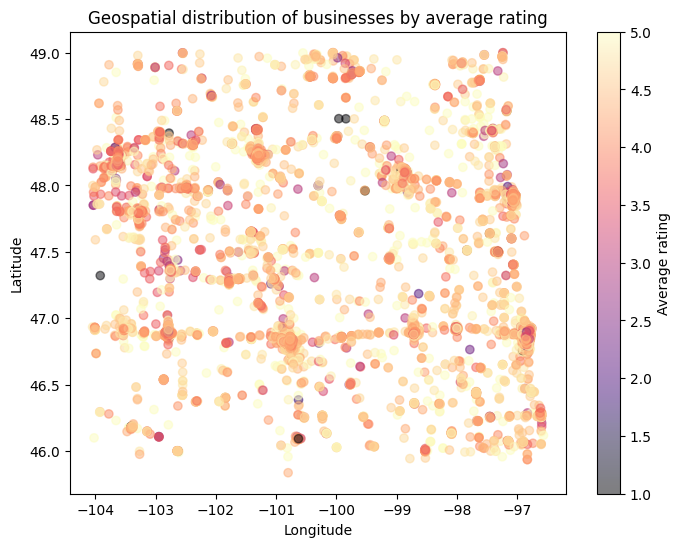

In [58]:
# Geospatial plot showing distribution of businesses by their average rating
plt.figure(figsize=(8, 6))
plt.scatter(no_outliers['longitude'], no_outliers['latitude'], c=no_outliers['avg_rating'], cmap='magma', alpha=0.5)
plt.title('Geospatial distribution of businesses by average rating')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Average rating')
plt.show()

- In the above scatter plot, we can infer that in latitude near 47, all the businesses got the good average rating. And where the longitude is -100 and latitude is 48.5, we got two businesses with bad rating.

### *EDA on reviews-North Dakota dataset containing information about reviews*

In [35]:
df_review = pd.read_json(r'D:\Study\Project\RecSys\CP-02\review-North_Dakota.json', lines=True)

In [37]:
df_review.shape

(1109558, 8)

- The review dataset contains 1.1M reviews of different users

In [39]:
df_review.describe()

,user_id,time,rating
count,1.098436e+06,1.109558e+06,1.098436e+06
mean,1.092236e+20,1.551001e+12,4.242010e+00
std,5.319717e+18,4.281232e+10,1.185204e+00
min,1.000001e+20,1.149206e+12,1.000000e+00
25%,1.046172e+20,1.523683e+12,4.000000e+00
50%,1.091758e+20,1.554486e+12,5.000000e+00
75%,1.138228e+20,1.581079e+12,5.000000e+00
max,1.184467e+20,1.631063e+12,5.000000e+00


- The 25% is the 25 percentile in IQR, which denotes that in user_id 1.046172e+20 this much amount of data falls in 25% of distribution in overall data

In [42]:
rating_counts = df_review['rating'].value_counts()
print("Number of reviews with respect to rating:\n", rating_counts)

Number of reviews with respect to rating:
 rating
5.0    668087
4.0    219772
3.0     95708
1.0     76809
2.0     38060
Name: count, dtype: int64


- Total no of reviews which has 5 star rating is 668087

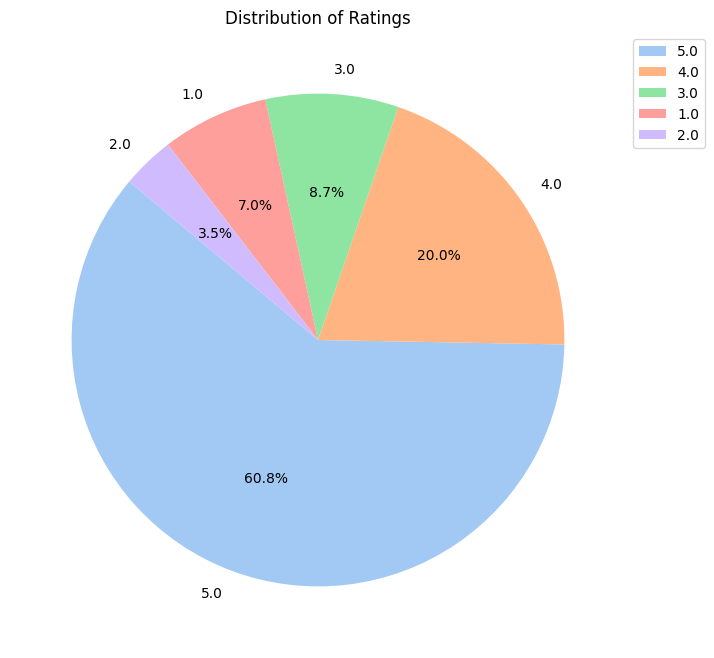

In [51]:
# Pie plot showing distribution of ratings
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'), textprops={'color': 'black'})
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")  
plt.title('Distribution of Ratings')
plt.show()

- Pie-plot of the above stats, Almost user has given the ratings 5 stars followed by 4,3,1,2 stars

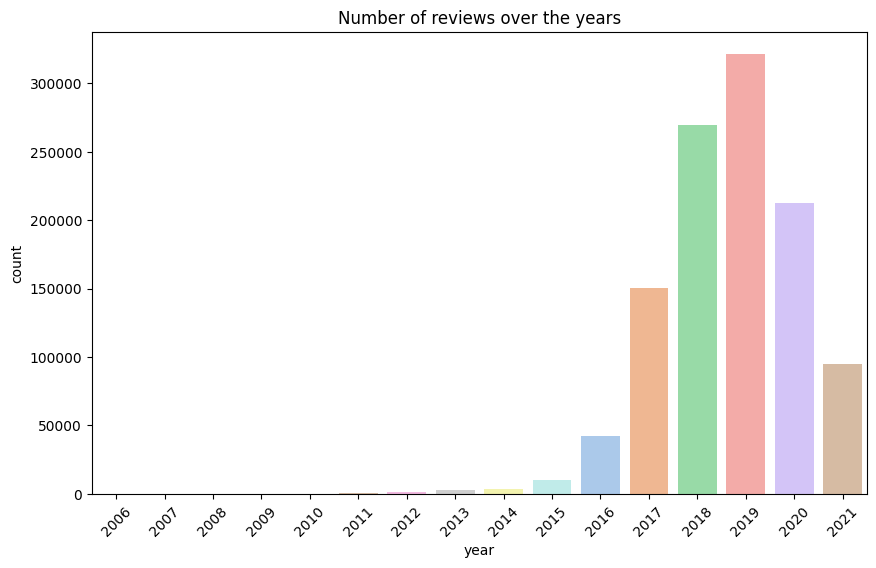

In [80]:
# Converting time
df_review['time'] = pd.to_datetime(df_review['time'], unit='ms')
df_review['year'] = df_review['time'].dt.year

# Plot to show number of reviews over the years
plt.figure(figsize=(10, 6)) 
sns.countplot(x='year', data=df_review, palette='pastel')
plt.title('Number of reviews over the years')
plt.xticks(rotation=45) 
plt.show()

- Maximum number of reviews came in 2019, which is more than 3 Lakhs, followed by 2018, 2020, 2017, 2021, 2016, 2015, ..

###  *EDA on the business name by merging the dataset*

In [74]:
# Merged dataframes
df_merged = pd.merge(df, df_review, on='gmap_id', how='inner')
df_merged.head()

,name_x,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,...,status,price_category,user_id,name_y,time,rating,text,pics,resp,year
0,St Peter & Paul Church,"St Peter & Paul Church, 500 Main St, Karlsruhe...",0x52d94fbefa0e6353:0xf709e2d8674fe3a,None,48.093248,-100.618664,[Catholic church],4.9,7,None,...,Unknown,NaN,1.088493e+20,أحمد آل إبراهيم,2020-09-19 12:15:59.614,5.0,I want to join Catholic Christ.,None,None,2020
1,St Peter & Paul Church,"St Peter & Paul Church, 500 Main St, Karlsruhe...",0x52d94fbefa0e6353:0xf709e2d8674fe3a,None,48.093248,-100.618664,[Catholic church],4.9,7,None,...,Unknown,NaN,1.137480e+20,John OpenMinded,2020-07-14 20:05:22.443,5.0,Its Catholic and devout. What more do you need?,None,None,2020
2,St Peter & Paul Church,"St Peter & Paul Church, 500 Main St, Karlsruhe...",0x52d94fbefa0e6353:0xf709e2d8674fe3a,None,48.093248,-100.618664,[Catholic church],4.9,7,None,...,Unknown,NaN,1.089884e+20,Juergen Wolf,2019-11-24 07:20:27.389,5.0,This was my Church in Karlsruhe. However in Ka...,None,None,2019
3,St Peter & Paul Church,"St Peter & Paul Church, 500 Main St, Karlsruhe...",0x52d94fbefa0e6353:0xf709e2d8674fe3a,None,48.093248,-100.618664,[Catholic church],4.9,7,None,...,Unknown,NaN,1.094611e+20,Jamie Lee,2019-11-01 11:49:11.549,4.0,Go with god,None,None,2019
4,St Peter & Paul Church,"St Peter & Paul Church, 500 Main St, Karlsruhe...",0x52d94fbefa0e6353:0xf709e2d8674fe3a,None,48.093248,-100.618664,[Catholic church],4.9,7,None,...,Unknown,NaN,1.177488e+20,lucas03,2020-11-02 17:58:56.721,5.0,(Translated by Google) everything faker not th...,None,None,2020


-  Plot of businesses with the most number of ratings

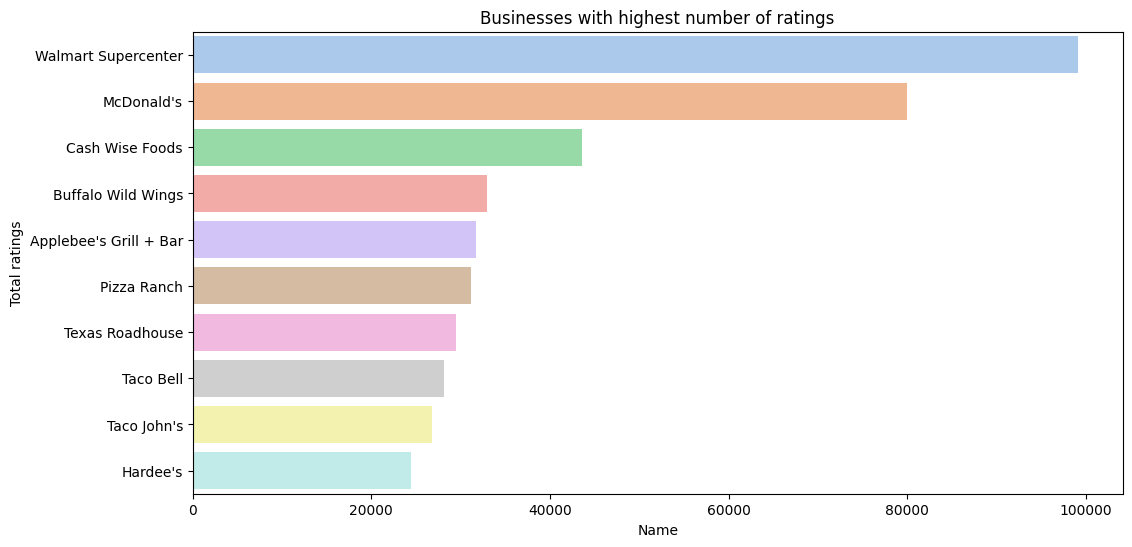

In [79]:
# Total ratings per company
company_reviews = df_merged.groupby('name_x')['rating'].sum().reset_index()

# Plot the graph
plt.figure(figsize=(12, 6))
sns.barplot(x='rating', y='name_x', data=company_reviews.sort_values(by='rating', ascending=False).head(10), palette='pastel')
plt.title('Businesses with highest number of ratings')
plt.xlabel('Name')
plt.ylabel('Total ratings')
plt.show()